In [1]:
# Log in to your Hugging Face account, requires token obtained from website

from huggingface_hub import notebook_login

notebook_login()

In [9]:
# Following https://huggingface.co/docs/transformers/tasks/image_captioning
# Other helpful info from https://huggingface.co/tasks/image-to-text

# Loading dataset
from datasets import load_dataset

ds = load_dataset("imagefolder", data_dir="./jn_data")
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 8
    })
    test: Dataset({
        features: ['image', 'text'],
        num_rows: 2
    })
})

In [10]:
# Split the dataset’s train split into a train and test set with the [~datasets.Dataset.train_test_split] method

train_ds = ds["train"]
test_ds = ds["test"]

In [11]:
train_ds

Dataset({
    features: ['image', 'text'],
    num_rows: 8
})

In [12]:
test_ds

Dataset({
    features: ['image', 'text'],
    num_rows: 2
})

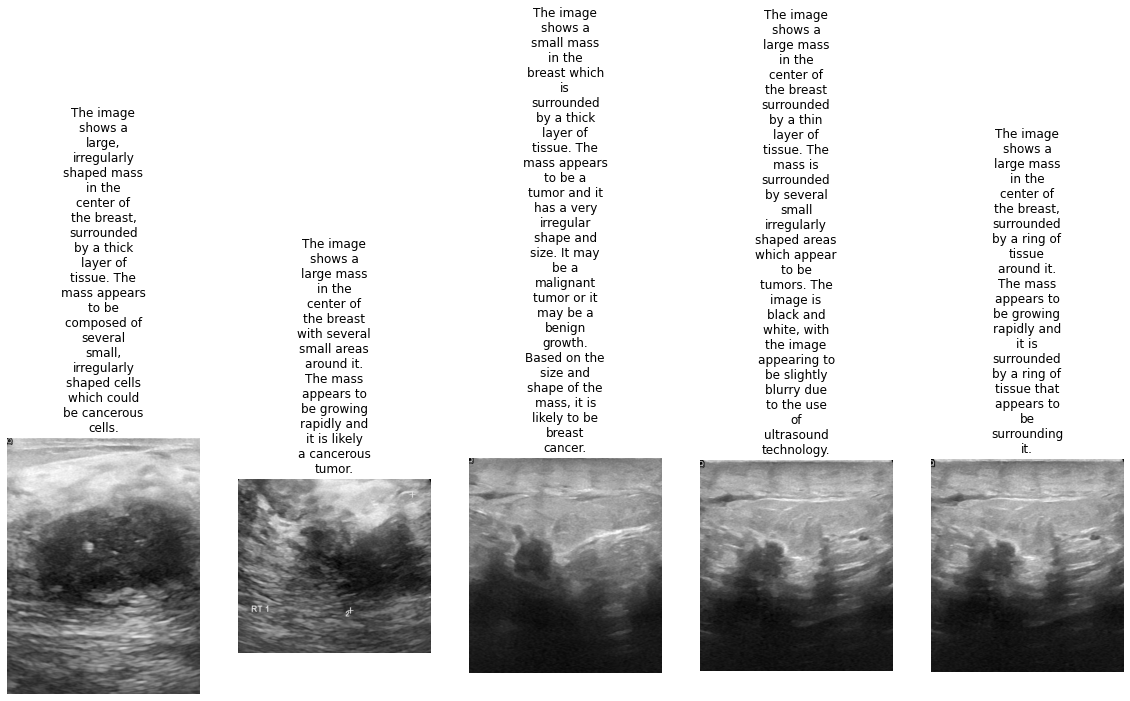

In [13]:
# Load the Pokémon BLIP captions dataset

from textwrap import wrap
import matplotlib.pyplot as plt
import numpy as np


def plot_images(images, captions):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        caption = captions[i]
        caption = "\n".join(wrap(caption, 12))
        plt.title(caption)
        plt.imshow(images[i])
        plt.axis("off")


sample_images_to_visualize = [np.array(train_ds[i]["image"]) for i in range(5)]
sample_captions = [train_ds[i]["text"] for i in range(5)]
plot_images(sample_images_to_visualize, sample_captions)

In [14]:
# Preprocess the dataset

from transformers import AutoProcessor

checkpoint = "microsoft/git-base"
processor = AutoProcessor.from_pretrained(checkpoint)

def transforms(example_batch):
    images = [x for x in example_batch["image"]]
    captions = [x for x in example_batch["text"]]
    inputs = processor(images=images, text=captions, padding="max_length")
    inputs.update({"labels": inputs["input_ids"]})
    return inputs


train_ds.set_transform(transforms)
test_ds.set_transform(transforms)

In [15]:
# Load base model
# Load the “microsoft/git-base” into a AutoModelForCausalLM object.

from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained(checkpoint)

In [16]:
# Evaluate -> code to do the evalution during training

from evaluate import load
import torch

wer = load("wer")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predicted = logits.argmax(-1)
    decoded_labels = processor.batch_decode(labels, skip_special_tokens=True)
    decoded_predictions = processor.batch_decode(predicted, skip_special_tokens=True)
    wer_score = wer.compute(predictions=decoded_predictions, references=decoded_labels)
    return {"wer_score": wer_score}

In [19]:
# Train - fine tuning
# pip install transformers[torch] -> needed to do this before running this code for the first time

from transformers import TrainingArguments, Trainer

model_name = checkpoint.split("/")[1]

training_args = TrainingArguments(
    output_dir=f"{model_name}-pokemon",
    learning_rate=5e-5,
    num_train_epochs=20,
    fp16=True,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=2,
    save_total_limit=3,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    save_steps=50,
    logging_steps=50,
    remove_unused_columns=False,
    push_to_hub=True,
    label_names=["labels"],
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

/home/ubuntu/git-base-pokemon is already a clone of https://huggingface.co/jonng1000/git-base-pokemon. Make sure you pull the latest changes with `repo.git_pull()`.


In [20]:
# Start training

trainer.train()

/home/ubuntu/.local/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


TrainOutput(global_step=40, training_loss=6.705043792724609, metrics={'train_runtime': 10.1264, 'train_samples_per_second': 15.8, 'train_steps_per_second': 3.95, 'total_flos': 74829222051840.0, 'train_loss': 6.705043792724609, 'epoch': 20.0})

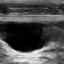

In [46]:
'''
# Inference

from PIL import Image
import requests

url = "https://huggingface.co/datasets/sayakpaul/sample-datasets/resolve/main/pokemon.png"
image = Image.open(requests.get(url, stream=True).raw)
image
'''
# Inference

from PIL import Image
import requests

image = Image.open('./jn_captioning/generated_image_1.png')
image

In [47]:
# Prep image
device = "cuda" if torch.cuda.is_available() else "cpu"

inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

#Call generate and decode the predictions.
generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

the image shows a large mass in the breast with several small areas around it. the mass appears to be growing rapidly and it is surrounded by a ring of tissue. the mass appears to be the mass is surrounded by a cancer.
